In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

In [5]:
data = pd.read_csv("Daily_public.csv",header = 0, parse_dates = [0])

/tmp/ipython-input-2131797741.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv("Daily_public.csv",header = 0, parse_dates = [0])


In [6]:
data.head(10)

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2024-08-30,16436,10705,225,19026,3925,59.0
1,2023-09-15,15499,10671,267,18421,4519,61.0
2,2021-12-28,1756,2352,0,3775,0,13.0
3,2023-01-11,10536,8347,223,14072,0,48.0
4,2021-09-11,820,612,0,1283,0,11.0
5,2020-01-31,12977,9620,242,19327,0,0.0
6,2023-03-01,17387,11627,362,21753,5544,108.0
7,2021-07-17,2735,3651,0,5236,0,20.0
8,2023-03-07,17674,11859,364,21560,5700,91.0
9,2020-11-12,13405,6989,273,13688,4983,74.0


In [7]:
data.shape

(1918, 7)

In [13]:
df = data.sort_values(by='Date')

In [14]:
df.reset_index(drop=True, inplace=True)

In [29]:
df.head(10)

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,is_holiday,day_of_week,is_weekend,is_weekday
0,2019-07-01,15987,9962,407,21223,3715,0.0,0,0,0,1
1,2019-07-02,16895,10656,409,21715,3993,0.0,0,1,0,1
2,2019-07-03,16613,10658,427,22025,3638,0.0,0,2,0,1
3,2019-07-04,16604,10445,437,21868,3576,0.0,0,3,0,1
4,2019-07-05,16040,10532,400,20697,2856,0.0,0,4,0,1
5,2019-07-06,5214,6141,0,6925,0,0.0,0,5,1,0
6,2019-07-07,4065,4332,0,5426,0,0.0,0,6,1,0
7,2019-07-08,13078,9442,422,18848,0,0.0,0,0,0,1
8,2019-07-09,13835,10550,455,19862,0,1.0,0,1,0,1
9,2019-07-10,13856,10066,421,19502,0,1.0,0,2,0,1


In [31]:
df.tail(10)

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,is_holiday,day_of_week,is_weekend,is_weekday
1908,2024-09-20,485,2537,0,440,37,0.0,0,4,0,1
1909,2024-09-21,28,832,0,64,0,0.0,0,5,1,0
1910,2024-09-22,21,577,0,49,0,0.0,0,6,1,0
1911,2024-09-23,56,1938,0,67,10,0.0,0,0,0,1
1912,2024-09-24,36,78,0,21,3,0.0,0,1,0,1
1913,2024-09-25,21,0,1,10,8,0.0,0,2,0,1
1914,2024-09-26,9,0,0,0,2,0.0,0,3,0,1
1915,2024-09-27,6,0,0,13,0,0.0,0,4,0,1
1916,2024-09-28,1,0,0,4,0,0.0,0,5,1,0
1917,2024-09-29,1,0,0,3,0,0.0,0,6,1,0


Preprocessing and Feature Engineering


In [37]:
import holidays
in_holidays = holidays.India()

df['is_holiday'] = df['Date'].astype('datetime64[ns]').isin(in_holidays).astype(int)

In [23]:
df['day_of_week'] = df['Date'].dt.dayofweek  # 0=Mon ... 6=Sun

# Create weekend & weekday flags
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['is_weekday'] = (~df['Date'].dt.dayofweek.isin([5,6])).astype(int)

In [43]:
import pandas as pd
import holidays

in_holidays = holidays.India()

# Make sure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Compare using the pure date part
df['is_holiday'] = df['Date'].dt.date.apply(
    lambda d: 1 if d in in_holidays else 0
)


In [44]:
holiday_rows = df[df['is_holiday'] == 1]
print(holiday_rows[['Date', 'is_holiday']])


           Date  is_holiday
42   2019-08-12           1
45   2019-08-15           1
54   2019-08-24           1
71   2019-09-10           1
93   2019-10-02           1
...         ...         ...
1813 2024-06-17           1
1843 2024-07-17           1
1872 2024-08-15           1
1883 2024-08-26           1
1904 2024-09-16           1

[85 rows x 2 columns]


In [26]:
df = df.fillna(0)


Trends and sesonality


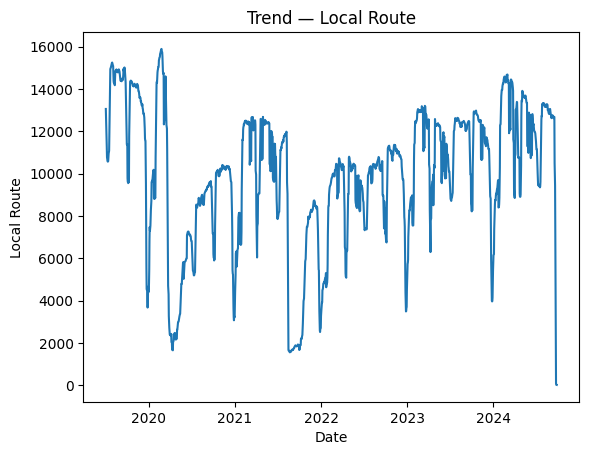

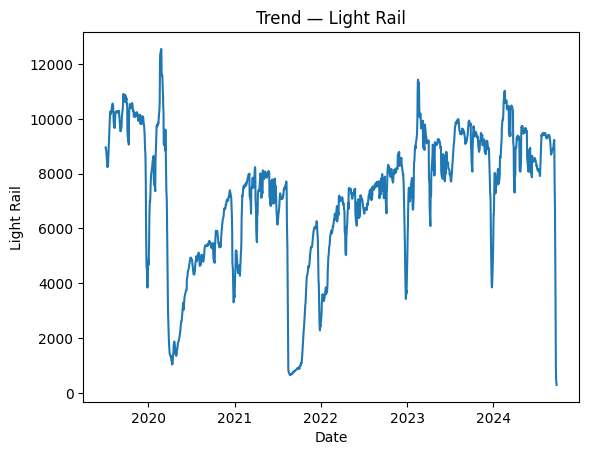

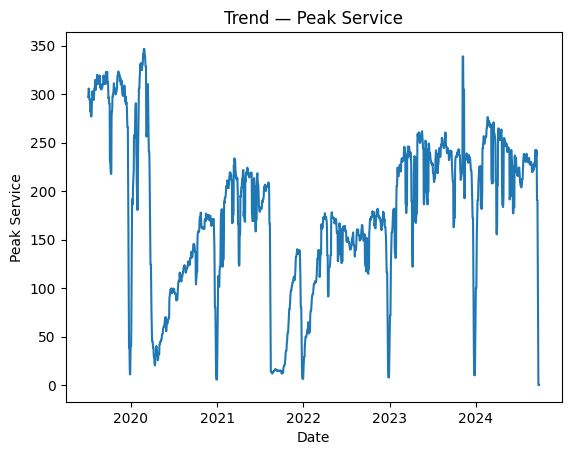

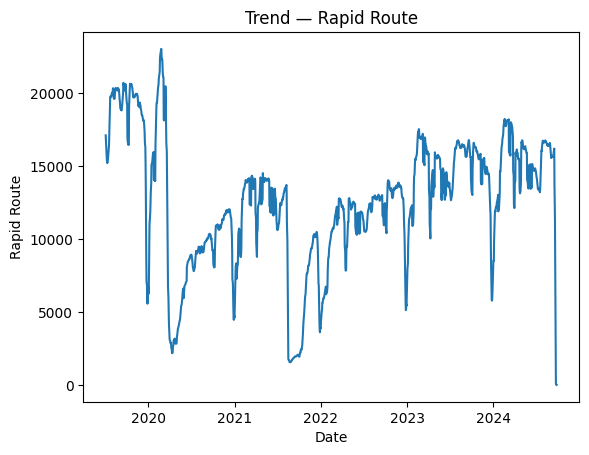

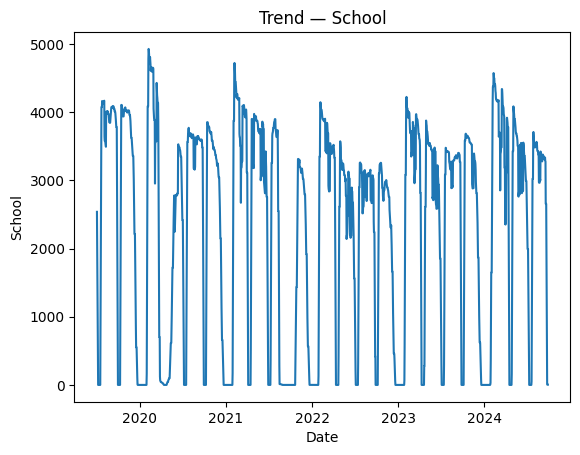

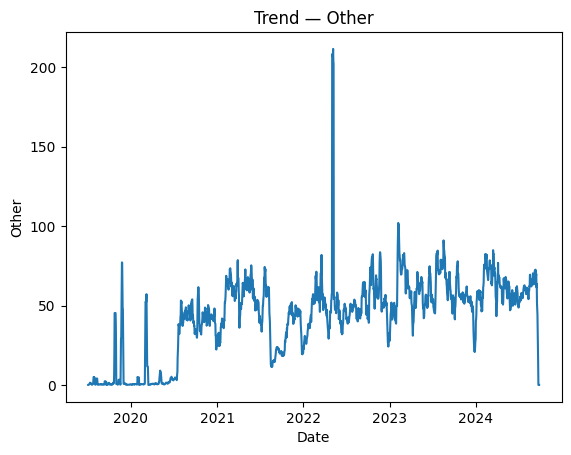

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

cols = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']

df['Date'] = pd.to_datetime(df['Date'])

for c in cols:
    decomposition = seasonal_decompose(df[c], model='additive', period=7)
    trend = decomposition.trend.dropna()

    plt.figure()
    plt.plot(df['Date'][trend.index], trend)
    plt.title(f"Trend — {c}")
    plt.xlabel("Date")
    plt.ylabel(c)


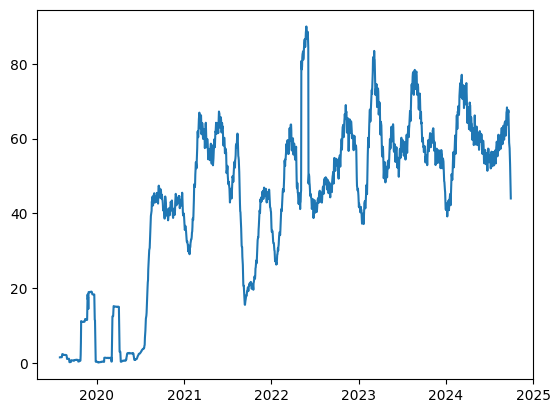

In [46]:
trend = df[c].rolling(30).mean()
plt.plot(df['Date'], trend)


Top transports on weekdays:


<Axes: >

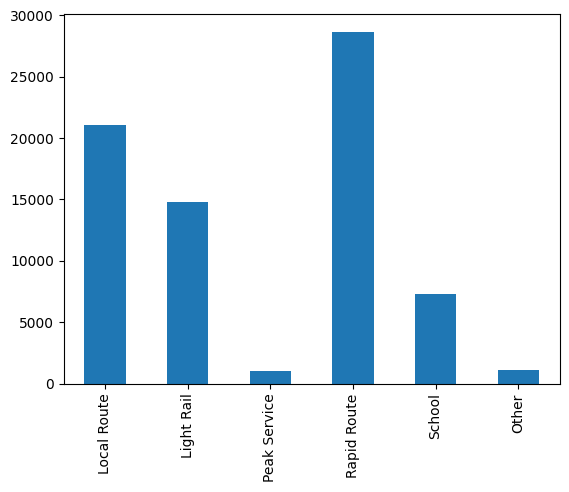

In [52]:
transport_cols = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']


weekday_usage = df[df['is_weekday'] == 1][transport_cols].max()
print("Top transports on weekdays:")
weekday_usage.plot(kind = 'bar')






Top transports on weekends:


<Axes: >

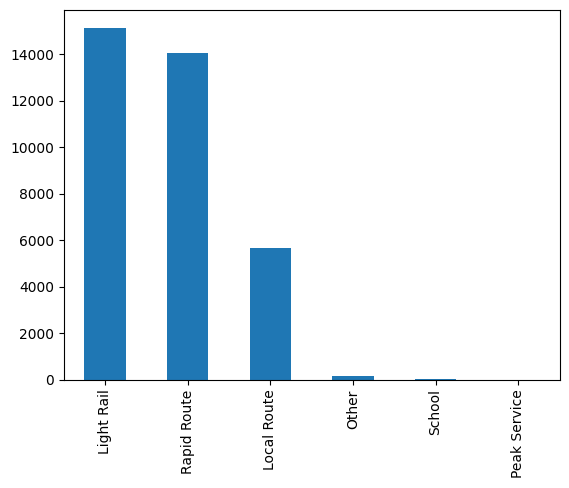

In [53]:
weekend_usage = df[df['is_weekend'] == 1][transport_cols].max()
print("\nTop transports on weekends:")
weekend_usage.plot(kind = 'bar')




Top transports on holidays:


<Axes: >

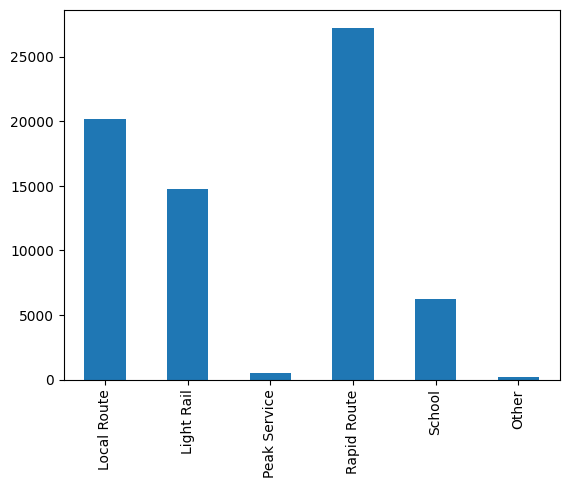

In [55]:

holiday_usage = df[df['is_holiday'] == 1][transport_cols].max()
print("\nTop transports on holidays:")
holiday_usage.plot(kind = 'bar')

Data training

In [97]:
train_size = int(df.shape[0] * 0.9)
train, test = df[0:train_size], df[train_size:]

In [98]:
train_size

1726

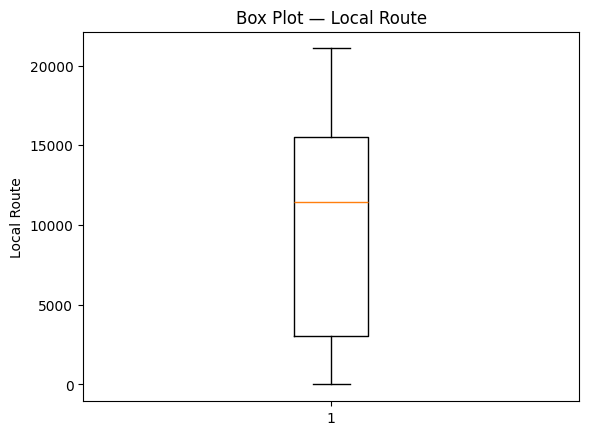

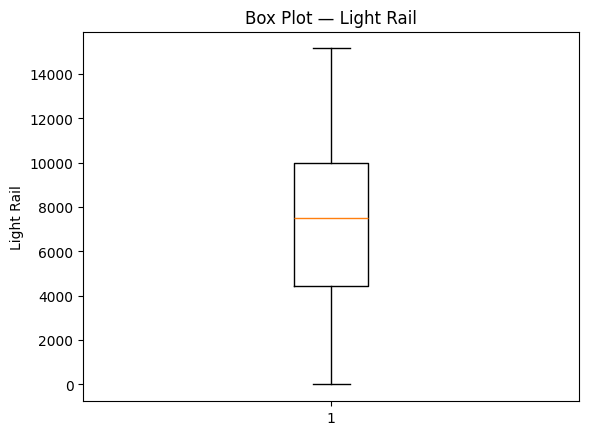

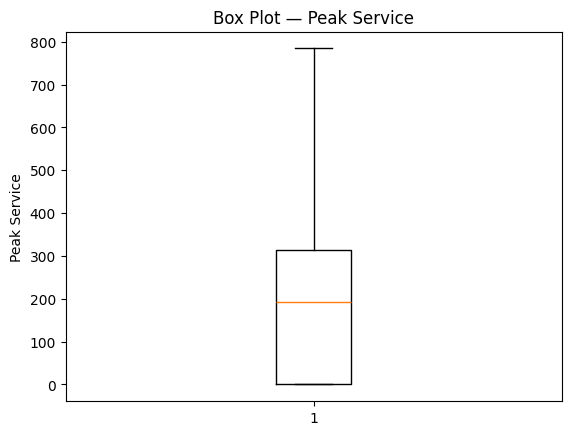

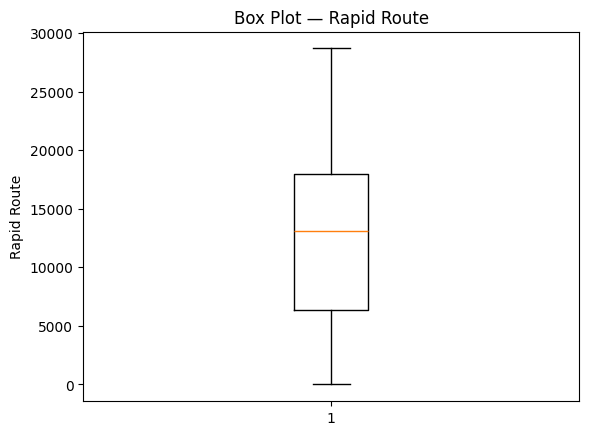

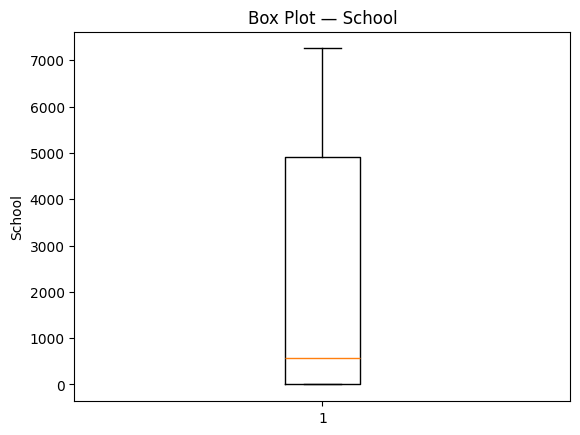

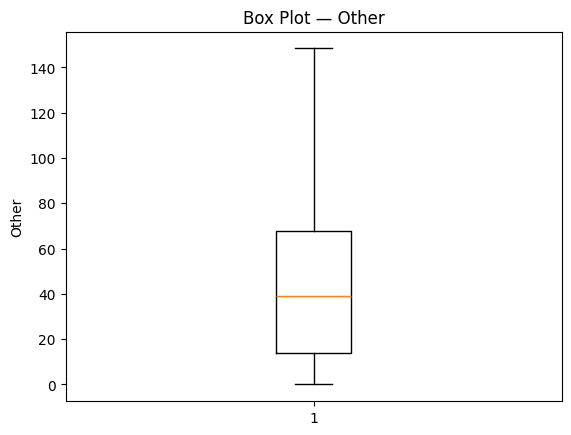

In [99]:
import matplotlib.pyplot as plt

transport_cols = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']

for c in transport_cols:
    plt.figure()
    plt.boxplot(df[c].dropna())
    plt.title(f"Box Plot — {c}")
    plt.ylabel(c)


In [79]:
print(df.columns.tolist())


['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other', 'is_holiday', 'day_of_week', 'is_weekend', 'is_weekday', 'Local Route_trend', 'Local Route_seasonal', 'Light Rail_trend', 'Light Rail_seasonal', 'Peak Service_trend', 'Peak Service_seasonal', 'Rapid Route_trend', 'Rapid Route_seasonal', 'School_trend', 'School_seasonal', 'Other_trend', 'Other_seasonal']


In [80]:
def label_day_type(row):
    if row['is_holiday'] == 1:
        return "Holiday"
    elif row['is_weekend'] == 1:  # weekend but not holiday
        return "Weekend"
    else:
        return "Weekday"

df['day_type'] = df.apply(label_day_type, axis=1)
# Outlier bounds using IQR
Q1 = df['Other'].quantile(0.25)
Q3 = df['Other'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Extract outlier rows
outlier_rows = df[(df['Other'] < lower) | (df['Other'] > upper)].copy()

# Show with day type
print(outlier_rows[['Date','Other','day_type']].head(20))


           Date   Other day_type
118  2019-10-27   171.0  Holiday
249  2020-03-06   150.0  Weekday
639  2021-03-31   161.0  Weekday
1040 2022-05-06  1105.0  Weekday
1241 2022-11-23   176.0  Weekday
1316 2023-02-06   160.0  Weekday
1340 2023-03-02   159.0  Weekday
1481 2023-07-21   151.0  Weekday
1500 2023-08-09   149.0  Weekday
1512 2023-08-21   162.0  Weekday


In [81]:
Q1 = df['Peak Service'].quantile(0.25)
Q3 = df['Peak Service'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Extract outlier rows
outlier_rows = df[(df['Peak Service'] < lower) | (df['Peak Service'] > upper)].copy()

# Show with day type
print(outlier_rows[['Date','Peak Service','day_type']].head(20))

           Date  Peak Service day_type
1593 2023-11-10          1029  Weekday


In [83]:
for c in ['Other', 'Peak Service']:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    upper_cap = Q3 + 1.5 * IQR

    # Apply capping
    df[c] = df[c].apply(lambda x: upper_cap if x > upper_cap else x)

    print(f"{c} capped at:", upper_cap)


Other capped at: 148.375
Peak Service capped at: 784.375


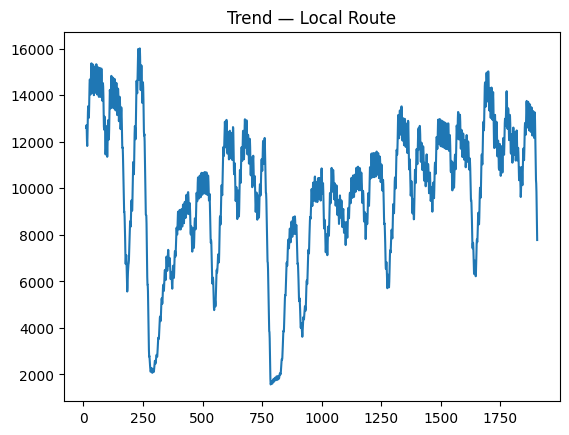

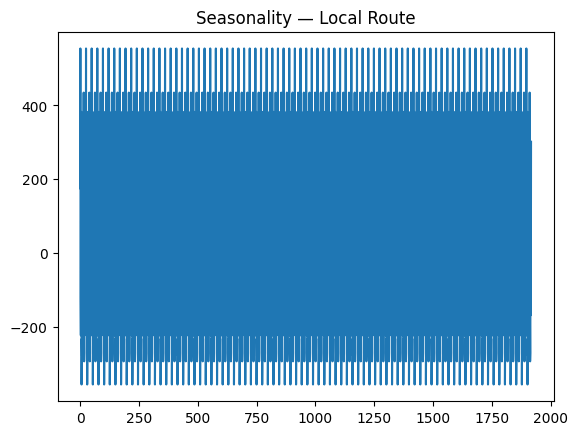

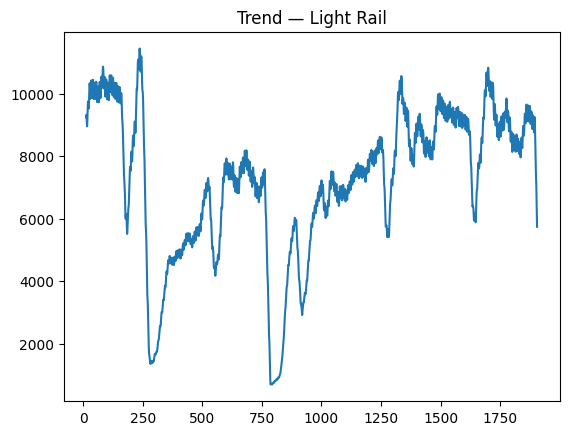

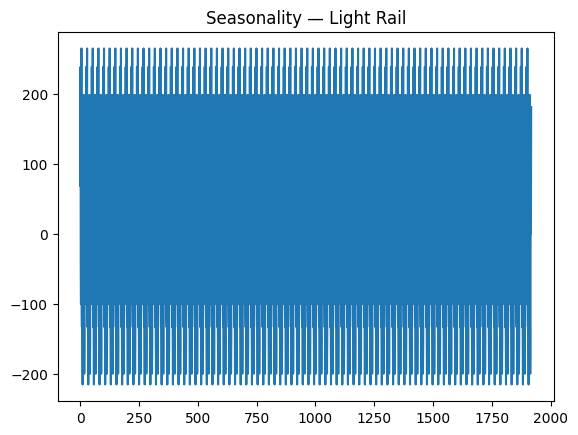

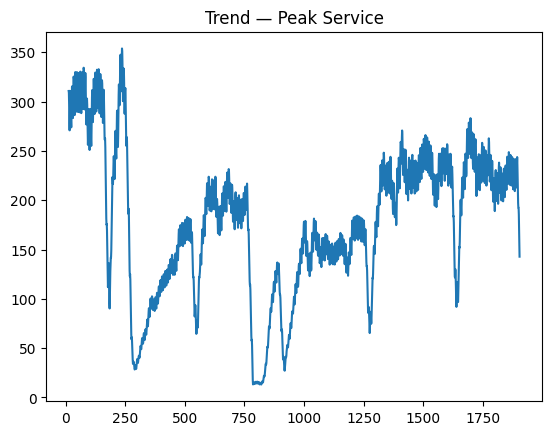

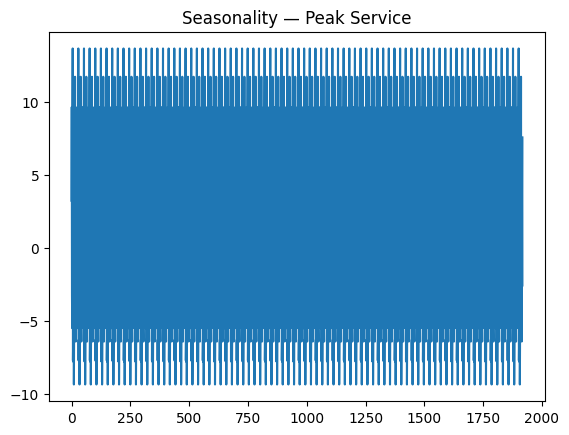

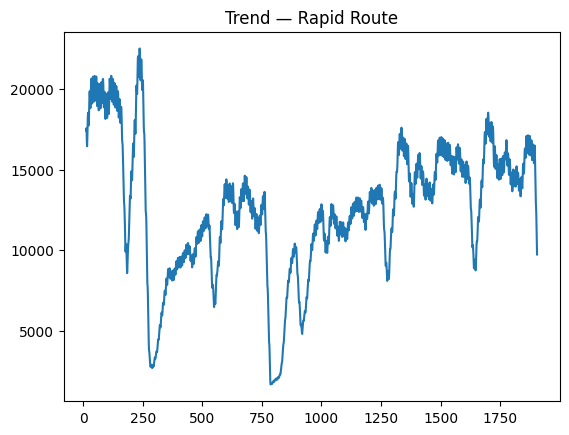

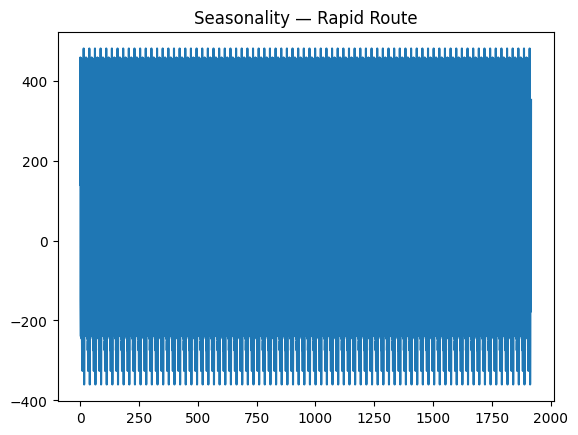

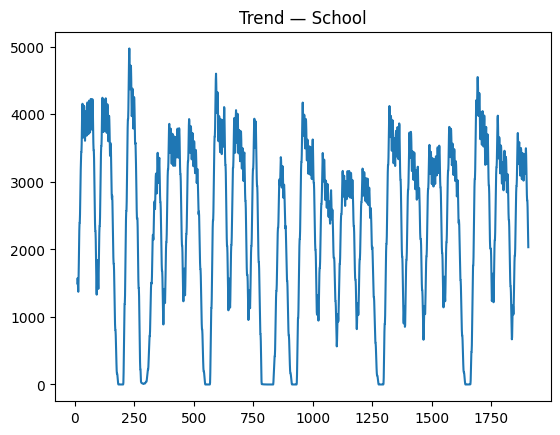

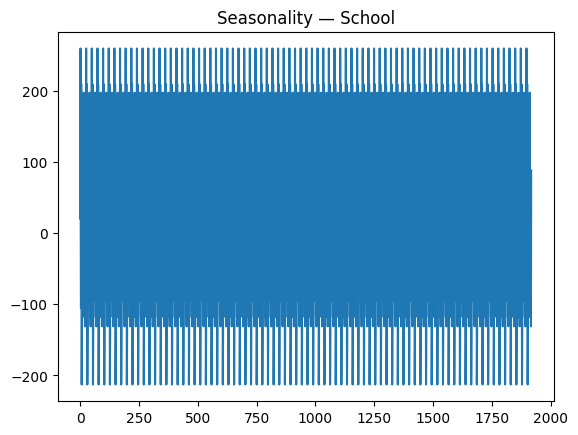

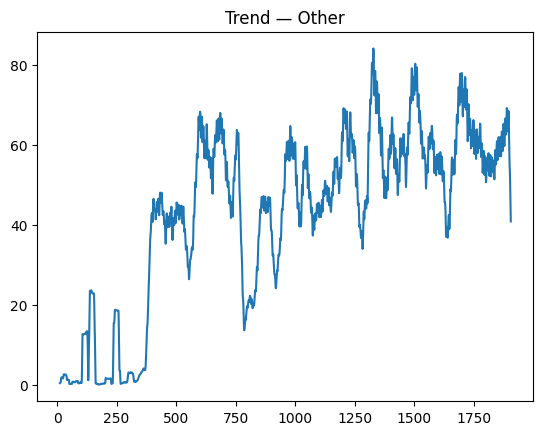

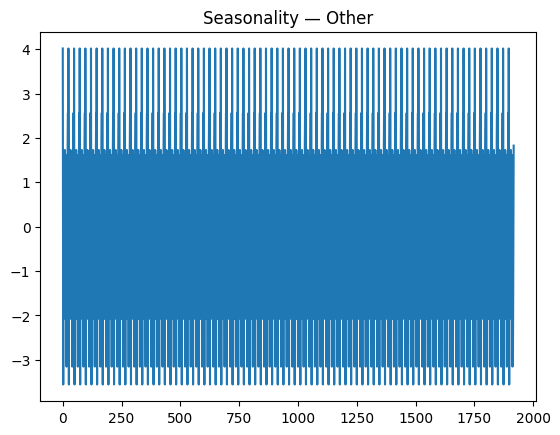

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

cols = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']

for c in cols:
    result = seasonal_decompose(df[c], model='additive', period=24)

    df[f"{c}_trend"] = result.trend
    df[f"{c}_seasonal"] = result.seasonal

    # Plot trend
    plt.figure()
    plt.plot(df[f"{c}_trend"].dropna())
    plt.title(f"Trend — {c}")

    # Plot seasonality
    plt.figure()
    plt.plot(df[f"{c}_seasonal"].dropna())
    plt.title(f"Seasonality — {c}")


Using Models

In [109]:
test.tail()

,ds,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,is_holiday,day_of_week,is_weekend,is_weekday,Local Route_trend,Local Route_seasonal,Light Rail_trend,Light Rail_seasonal,Peak Service_trend,Peak Service_seasonal,Rapid Route_trend,Rapid Route_seasonal,School_trend,School_seasonal,Other_trend,Other_seasonal,day_type
1913,2024-09-25,21,0,1.0,10,8,0.0,0,2,0,1,NaN,-292.001038,NaN,-199.655150,NaN,-4.895251,NaN,-360.177136,NaN,-39.759717,NaN,1.609853,Weekday
1914,2024-09-26,9,0,0.0,0,2,0.0,0,3,0,1,NaN,-269.412958,NaN,-155.258262,NaN,-6.399470,NaN,-246.735944,NaN,-118.230708,NaN,-2.795474,Weekday
1915,2024-09-27,6,0,0.0,13,0,0.0,0,4,0,1,NaN,251.926441,NaN,159.882561,NaN,3.914348,NaN,315.533043,NaN,-33.180075,NaN,-1.542573,Weekday
1916,2024-09-28,1,0,0.0,4,0,0.0,0,5,1,0,NaN,-167.340173,NaN,0.773120,NaN,-2.621517,NaN,-177.972758,NaN,-131.097269,NaN,0.544453,Weekend
1917,2024-09-29,1,0,0.0,3,0,0.0,0,6,1,0,NaN,301.707031,NaN,181.398647,NaN,7.585762,NaN,351.915691,NaN,88.002942,NaN,1.826098,Weekend


In [104]:
train.tail()

,ds,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,is_holiday,day_of_week,is_weekend,is_weekday,Local Route_trend,Local Route_seasonal,Light Rail_trend,Light Rail_seasonal,Peak Service_trend,Peak Service_seasonal,Rapid Route_trend,Rapid Route_seasonal,School_trend,School_seasonal,Other_trend,Other_seasonal,day_type
1721,2024-03-17,2856,4739,0.0,6702,0,17.0,0,6,1,0,13786.104167,-292.001038,10181.083333,-199.655150,251.187500,-4.895251,17270.395833,-360.177136,3923.416667,-39.759717,71.833333,1.609853,Weekend
1722,2024-03-18,18155,11450,392.0,20665,5971,123.0,0,0,0,1,13133.125000,-269.412958,9872.104167,-155.258262,234.166667,-6.399470,16591.250000,-246.735944,3748.187500,-118.230708,68.437500,-2.795474,Weekday
1723,2024-03-19,19306,12747,423.0,22837,6025,82.0,0,1,0,1,12457.291667,251.926441,9574.604167,159.882561,218.229167,3.914348,15950.833333,315.533043,3495.375000,-33.180075,64.541667,-1.542573,Weekday
1724,2024-03-20,18958,12303,411.0,21981,5823,88.0,0,2,0,1,11787.395833,-167.340173,9248.437500,0.773120,204.291667,-2.621517,15284.687500,-177.972758,3254.333333,-131.097269,60.937500,0.544453,Weekday
1725,2024-03-21,18838,12491,334.0,21939,5524,111.0,0,3,0,1,11728.937500,301.707031,9162.833333,181.398647,206.208333,7.585762,15169.770833,351.915691,3252.208333,88.002942,62.020833,1.826098,Weekday


In [102]:
test.shape

(192, 24)

SARIMAX


In [120]:
!pip install pmdarima
from pmdarima import auto_arima

auto_arima(train['Peak Service'], seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=20470.328, Time=12.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22021.788, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=21798.466, Time=1.63 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=21620.481, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22019.789, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=20481.296, Time=9.00 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=20485.705, Time=12.20 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=20812.651, Time=30.77 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=32.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=20674.035, Time=5.94 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=20482.563, Time=25.32 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=20811.733, Time=27.63 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=34.42 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=21046.730, Time=10.19 sec
 ARIMA(2,

ARIMA(order=(5, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Peak Service'],order = (5,1,2),seasonal_order = (1,1,1,12))

In [126]:
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
residuals = model_fit.resid

<Axes: >

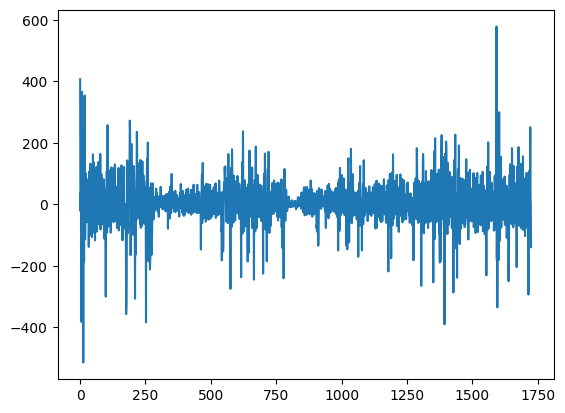

In [128]:
residuals.plot()
# if we get white noise (data with no pattern) the model has learnt all parameters

In [133]:
output = model_fit.forecast(192)

In [134]:
output.head()

,predicted_mean
1726,287.489254
1727,4.365284
1728,11.694904
1729,267.641010
1730,450.153136


In [135]:
mse = mean_squared_error(test['Peak Service'], output)
mae = mean_absolute_error(test['Peak Service'], output)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Peak Service'], output)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MSE: 10249.807537318089
MAE: 79.67744569908609
RMSE: 101.24133314668515
MAPE: 1.5164306061767107e+17


<Axes: >

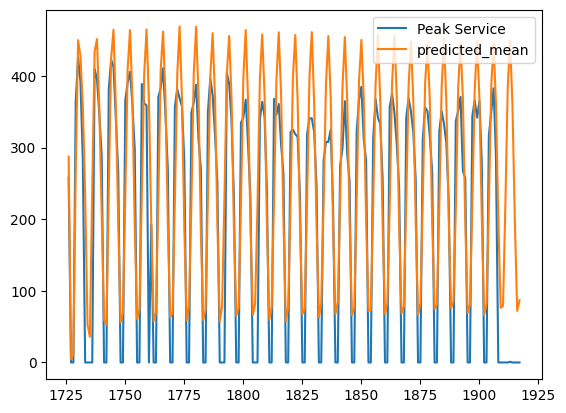

In [137]:
com = pd.concat([test['Peak Service'],output], axis=1)
com.plot()

Prophet

In [86]:
!pip install prophet
from prophet import Prophet



In [106]:
model = Prophet()
for r in regressors:
    model.add_regressor(r)

model.fit(prophet_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:

if train.index.name == 'Date':
    train = train.reset_index().rename(columns={'Date':'ds'})
else:
    train = train.rename(columns={'Date':'ds'})

prophet_df = train[['ds', 'Peak Service']].rename(columns={'Peak Service':'y'})


regressors = ['Local Route','Light Rail','Rapid Route','School','Other','is_weekend','is_holiday']
for r in regressors:
    prophet_df[r] = train[r]

print(prophet_df.head())


          ds      y  Local Route  ...  Other  is_weekend  is_holiday
0 2019-07-01  407.0        15987  ...    0.0           0           0
1 2019-07-02  409.0        16895  ...    0.0           0           0
2 2019-07-03  427.0        16613  ...    0.0           0           0
3 2019-07-04  437.0        16604  ...    0.0           0           0
4 2019-07-05  400.0        16040  ...    0.0           0           0

[5 rows x 9 columns]


In [110]:
future = model.make_future_dataframe(periods=192, freq='D')

for r in regressors:
    if r not in ['is_weekend','is_holiday']:
        future[r] = df[r].iloc[-30:].mean()

future['is_weekend'] = future['ds'].dt.weekday.isin([5,6]).astype(int)
import holidays
in_holidays = holidays.India()
future['is_holiday'] = future['ds'].dt.date.isin(in_holidays).astype(int)

forecast = model.predict(future)


In [111]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Light Rail,Light Rail_lower,Light Rail_upper,Local Route,Local Route_lower,Local Route_upper,Other,Other_lower,Other_upper,Rapid Route,Rapid Route_lower,Rapid Route_upper,School,School_lower,School_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,is_holiday,is_holiday_lower,is_holiday_upper,is_weekend,is_weekend_lower,is_weekend_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-01,179.358576,123.824194,200.809826,179.358576,179.358576,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-16.384854,-16.384854,-16.384854,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.659319,5.659319,5.659319,18.845707,18.845707,18.845707,0.0,0.0,0.0,162.973722
1,2019-07-02,179.405034,121.803984,197.461019,179.405034,179.405034,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-16.841724,-16.841724,-16.841724,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.385330,5.385330,5.385330,18.662825,18.662825,18.662825,0.0,0.0,0.0,162.563310
2,2019-07-03,179.451493,121.547514,199.340148,179.451493,179.451493,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-19.276617,-19.276617,-19.276617,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.202587,3.202587,3.202587,18.410675,18.410675,18.410675,0.0,0.0,0.0,160.174875
3,2019-07-04,179.497951,101.710512,178.378007,179.497951,179.497951,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-39.224397,-39.224397,-39.224397,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,-16.420493,-16.420493,-16.420493,18.085976,18.085976,18.085976,0.0,0.0,0.0,140.273554
4,2019-07-05,179.544409,70.357792,144.338411,179.544409,179.544409,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-71.010236,-71.010236,-71.010236,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,-47.805927,-47.805927,-47.805927,17.685572,17.685572,17.685572,0.0,0.0,0.0,108.534174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1913,2024-09-25,212.365099,133.867220,216.125148,208.596561,216.532741,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-38.013040,-38.013040,-38.013040,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.202587,3.202587,3.202587,-0.325747,-0.325747,-0.325747,0.0,0.0,0.0,174.352059
1914,2024-09-26,212.403746,116.249418,194.055419,208.612400,216.612882,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-57.726852,-57.726852,-57.726852,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.000000,0.000000,-16.420493,-16.420493,-16.420493,-0.416480,-0.416480,-0.416480,0.0,0.0,0.0,154.676894
1915,2024-09-27,212.442393,84.226069,164.270919,208.612487,216.683944,16.019449,16.019449,16.019449,-22.005659,-22.005659,-22.005659,-0.130733,-0.130733,-0.130733,-36.585113,-36.585113,-36.585113,1.812177,1.812177,1.812177,-89.260624,-89.260624,-89.260624,-40.889880,-40.889880,-40.889880,0.0,0.0,0.0,0.000000,0.0000

In [118]:

print("peak_service forecast error:")
# Extract the forecasted values corresponding to the test set
forecast_test_period = forecast['yhat'].iloc[train_size:]

mse = mean_squared_error(test['Peak Service'], forecast_test_period)
mae = mean_absolute_error(test['Peak Service'], forecast_test_period)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Peak Service'], forecast_test_period)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

peak_service forecast error:
MSE: 26531.24259145607
MAE: 159.90618657592418
RMSE: 162.88413855086097
MAPE: 2.3301542488416854e+17


In [115]:
combine1 = pd.concat([test['Peak Service'], forecast['yhat']], axis=1)
combine1.head()

,Peak Service,yhat
1726,258.0,115.371094
1727,0.0,128.685226
1728,0.0,153.590179
1729,364.0,176.067588
1730,426.0,178.013904


<Axes: >

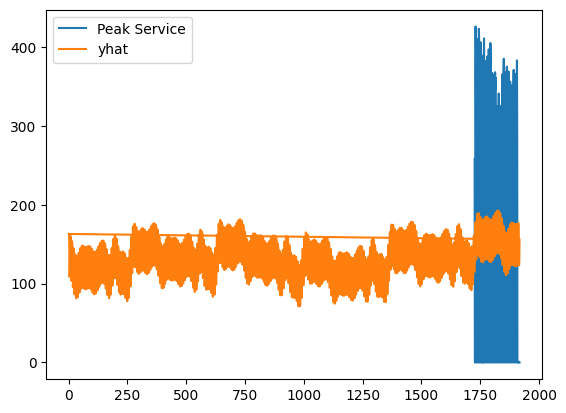

In [116]:
combine1.plot()